<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT22/blob/leogabac-Lab5/Lab5/leogabac_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Integration**
**Leonardo Gabriel Alanis Cantú**

# **Abstract**

In this report we look at the integration techniques known as "Gauss quadrature" and "Monte Carlo integration". The first is an exact method of integration for polynomials, and approximate for any other type of functiones, whereas Monte Carlo integration is based on random quadrature points, and convergence due to the massive amount of points that are usually used. These methods, were implemented in code, and the results were acceptable. A brief discussion about performance of the Monte Carlo integration on 2D domains is made in the last section of this document.

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
from numpy import mean
from math import *
from random import random
import matplotlib.pyplot as plt

# **Introduction**

One of the most common approximation methods for integrals is the Newton-Cotes scheme, which uses $q+1$ quadrature points is exact for polynomial integrans up to degree $q$. However, the Gauss quadrature scheme also uses $q+1$ quadrature points, but it is exact for polynomial integrands up to degree $2q+1$. The method relies on choosing polynomial $\phi \in \mathcal{P}^{q+1}([a,b])$ which is orthogonal by the inner product

$$
\int_a^b \phi(x)s(x) \text{ d}x = 0.
$$

Then we have (using the Lagrange basis)

$$
\int_a^b p(x) \text{ d}x = \int_a^b [ \phi(x) s(x) + r(x) ] \text{ d}x = \sum_{i=0}^q \int_a^b \lambda_i(x) \text{ d}x = \sum_{i=0}^q p(x_i) w_i
$$

Notice how we went from integrating a function, to just evaluating it in some 'magical' points and weights that need to be determined. The 'fun' part is to determine the quadrature points, and the weights that we need to use. Following equation (11.4) from the textbook we have

$$
\sum_{j=0}^q \varphi_i(x_j)w_j = \int_a^b \varphi_i(x) \text{ d}x , \quad i = 1, \ldots, 2q+1
$$

Quadrature points and weights are typically found in tables e.g.[this Wikipedia article](https://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss%E2%80%93Legendre_quadrature). The only problem with tables, it that they are usually given in the interval $[-1,1]$, for this report we want to integrate over interval $[0,1]$, to do this, we need a mapping (borrowed from my homework)

$$
F: [-1,1] \to [a,b],
$$

and the integral will be given by

$$
\int_{-1}^{1}f(x) \text{ d}x = \int_a^b f( F(\hat{x}) ) ~ |\det{F'}| \text{ d}x \approx |\det(F(\hat{x}))| \sum_{i=0}^q f(F(\hat{x}_i))w_i,
$$
here I will use the map $F(x) = (x+1)/2$. $F(-1) = 0, F(1) = 1$.

$$
\int_0^1 f(x) \text{ d}x = \dfrac{1}{2}\int_{-1}^1 f\left[ \dfrac{1}{2}(x+1)\right] \text{ d}x \approx \dfrac{1}{2}\sum_{i=0}^1 w_i f\left[ \dfrac{1}{2}(x_i+1)\right].
$$

The 2 point quadrature rule uses the weights and quadrature points

$$
x = \pm \dfrac{1}{\sqrt{3}}, \quad w_0 = w_1 = 1.
$$

Gauss quadrature can be extended to double integration. A 3-point rule which is exact for quadratic integrands is obtained by choosing the quadrature poitns as the midpoints of the three edges of the reference triangle, with weights $w_0 = w_1 = w_3 = 1/6$. The reference triangle is definde by the vertices $(0,0), (1,0), (0,1)$, i.e. the double integral

$$
\int_{0}^{1} \int_{0}^{1-x} f(x,y) \text{ d}y \text{ d}x.
$$

Therefore the weights and poins are
$$
w_0 = w_1 = w_2 = \dfrac{1}{6}, \quad x_0 = (1/2,0), x_1 = (0,1/2), x_2 = (1/2,1/2).
$$

Last but not least, _Monte Carlo integration_ also known as _integration by darts_. The idea is to sample quadrature points randomly in the domain of integration, and by the law of large numbers (see textbook Chapter 12.5) a definite integral can be approximated by averaging over them.

$$
\int_D g(x) \text{ d}x \approx \dfrac{|D|}{n}\sum_{i=1}^ng(x_i)
$$

# **Method**

Let us first implement the 2-point gaussian quadrature scheme.

In [3]:
def twop_gaussq(f,a,b):
    # ===== INPUT ===== #
    # f: Integrand function
    # a: start of interval
    # b: end of interval
    # ===== OUTPUT ===== #
    # Approximation of integral \int_a^b f(x) dx
    
    scale = (b-a)/2
    w = [1,1]
    x = [1/sqrt(3), -1/sqrt(3)]
    offset = (a+b)/2
    feval = [ f(scale*xi + offset ) for xi in x ]
    return scale*np.dot(w,feval)

3-point edge midpoint quadrature over the reference triangle

In [4]:
def threep_gaussq_reftriangle(f):
    # ===== INPUT ===== #
    # f: Integrand function
    # ===== OUTPUT ===== #
    # Approximation of integral \int_reftriangle f(x,y) dx dy
    
    w = [1/6, 1/6, 1/6]
    x = [ (1/2,0), (0,1/2), (1/2,1/2) ]
    feval = [ f(*xi) for xi in x ]
    return np.dot(w,feval)

Last, but not least, Monte Carlo integration.

In [5]:
def integration_by_darts01(f, darts = int(1e5) ):
    # ===== INPUT ===== #
    # f: Integrand function
    # darts: Number of quadrature points to generate
    # b: end of interval
    # ===== OUTPUT ===== #
    # Approximation of integral \int_0^1 f(x) dx
    
    x = np.random.rand(darts) # initialize
    L = 1 # Length of the interval
    
    feval = mean( [ f(xi) for xi in x ] )
    
    return L*feval

And an extra assignment, because I did it by accident.

In [6]:
def ref_triangle(x):
    return 1-x

def integration_by_darts(f, darts = int(1e5) ):
    # ===== INPUT ===== #
    # f: Integrand function
    # darts: Number of quadrature points to generate
    # b: end of interval
    # ===== OUTPUT ===== #
    # Approximation of integral \int_a^b f(x) dx
    
    x = np.zeros(darts) # initialize
    y = np.zeros(darts) # initialize
    fill = 0;
    # Generate points in mesh by trial and error :D (Inefficient, but it works, I guess?)
    while fill < darts:
        xi = random()
        yi = random()
        # make sure that point is in domain
        if yi <= ref_triangle(xi):
            x[fill] = xi
            y[fill] = yi
            fill += 1
    
    D = 1/2 # area of the reference triangle
    
    feval = mean( [ f(*p) for p in zip(x,y) ] )
    
    return D*feval

# **Results**

First, we are going to put to test the 2-point gauss quadrature method. In principle, this method integrates exactly any polynomial up to order three, so let us try with the following choices

$$
\int_0^1 (2x^3 - 3x^2 + 2x -7) \text{ d}x = -\dfrac{13}{2} = - 6.5\\
\int_0^1 (x^3 + 4x^2 - 6x +5) \text{ d}x = \dfrac{43}{12} = 3.5833\\
\int_0^1 (x^2 - 2x +1) \text{ d}x = \dfrac{1}{3}
$$

In [7]:
def f1(x):
    return 2*x**3 - 3*x**2 + 2*x - 7

def f2(x):
    return x**3 + 4*x**2 - 6*x + 5

def f3(x):
    return x**2 - 2*x + 1

approx1 = twop_gaussq(f1,0,1)
approx2 = twop_gaussq(f2,0,1)
approx3 = twop_gaussq(f3,0,1)
print("First result:", approx1)
print("Second result:", approx2)
print("Third result:", approx3)

First result: -6.5
Second result: 3.583333333333334
Third result: 0.3333333333333334


Secondly, we will test our implementation against exact integration of surfaces over the reference triangle.

$$
\int_{0}^{1} \int_{0}^{1-x} (x^2 + y^2 + xy) \text{ d}y \text{ d}x = \dfrac{5}{24} = 0.208333 \\
\int_{0}^{1} \int_{0}^{1-x} (3x^2 - y^2 + 4x - y - 4) \text{ d}y \text{ d}x = -\dfrac{4}{3} = -1.33333 \\
$$

In [8]:
def f4(x,y):
    return x*y + x**2 + y**2

def f5(x,y):
    return 3*x**2 - y**2 + 4*x - y -4

approx4 = threep_gaussq_reftriangle(f4)
approx5 = threep_gaussq_reftriangle(f5)
print("Fourth result:", approx4)
print("Fifth result:", approx5)

Fourth result: 0.20833333333333331
Fifth result: -1.3333333333333333


Then we are going to try to integrate some functions using the Monte Carlo methods

$$
\int_0^1 x\sin(x) \text{ d}x = \sin(1) - \cos(1) \approx 0.301169
$$

Sixth result: 0.3014850227695968


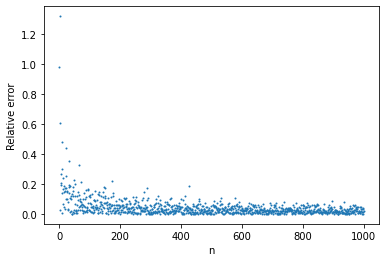

In [9]:
def f6(x):
    return x*sin(x)

def verify_montecarlo(f, top = 1000):
    exact = 0.301169
    errors = [] # initialize
    for k in range(top):
        approx = integration_by_darts01(f, darts = k+1)
        epsilon = abs(approx - exact)/abs(exact)
        errors.append(epsilon)
    return errors


approx6 = integration_by_darts01(f6)
print("Sixth result:", approx6)

max = int(1e3)
n = [k+1 for k in range(max)]
epsilon = verify_montecarlo(f6, top = max)
plt.scatter(n,epsilon, s = 1)
plt.xlabel("n")
plt.ylabel("Relative error")
plt.show()

Finally we are going to test Monte Carlo integration on the reference triangle.

$$
\int_{0}^{1} \int_{0}^{1-x} xy\cos(x)\sin(y) \text{ d}y \text{ d}x = \dfrac{1}{12} (5\cos(1) - 3 \sin(1)) \approx 0.0147582
$$

Seventh result: 0.014780066286818152


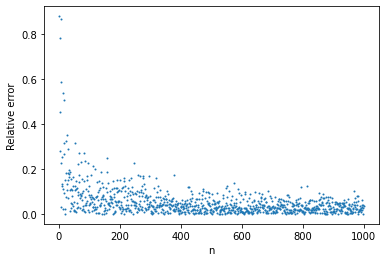

In [10]:
def f7(x,y):
    return x*y*cos(x)*sin(y)

def verify_montecarlo2(f, top = 1000):
    exact = 0.0147582
    errors = [] # initialize
    for k in range(top):
        approx = integration_by_darts(f, darts = k+1)
        epsilon = abs(approx - exact)/abs(exact)
        errors.append(epsilon)
    return errors


approx7 = integration_by_darts(f7)
print("Seventh result:", approx7)

max = int(1e3)
n = [k+1 for k in range(max)]
epsilon = verify_montecarlo2(f7, top = max)
plt.scatter(n,epsilon, s = 1)
plt.xlabel("n")
plt.ylabel("Relative error")
plt.show()

In [ ]:
import time
start_time = time.time()
int_approx = integration_by_darts(f7, darts = int(1e8))
print("--- %s seconds ---" % (time.time() - start_time))

--- 341.31490778923035 seconds ---


# **Discussion**

I was personally amazed at how well the algorithms permorm, which is expected, since these methods are exact for the tests that were given; however, there is still some amazement by just seeing them in action. All tasks were passed successfully with no further complication.

The fun part comes from Monte Carlo integration over the reference triangle, the "tricky" part came from choosing random points in the given domain. The method implemented in this report was a "discard" scheme, i.e. a point is generated, and if it is not in the domain, we just discard it. 

Various problems arise when we start dealing with large amounts of points, as seen in the last test.It is uncertain whether there is a "better" way to code this idea in Python, but the same snippet of [code](https://drive.google.com/file/d/1k1JVBODf7TUAe9TcN2FpA0A83t_906qT/view?usp=sharing) is type-stable in Julia and is around 72 times faster (4.700729 s for the same task). 

I am open to read suggestions regarding python optimization in the peer-review.
